In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import seaborn as sns
%matplotlib inline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,make_scorer
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, roc_auc_score

columnas = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
            'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


df1 = pd.read_csv('processed.cleveland.data', names=columnas)
df2 = pd.read_csv('processed.switzerland.data', names=columnas)
df3 = pd.read_csv('processed.hungarian.data', names=columnas)


df = pd.concat([df1, df2, df3], ignore_index=True)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,52.0,1.0,4.0,160,331,0,0,94,1,2.5,?,?,?,1
716,54.0,0.0,3.0,130,294,0,1,100,1,0.0,2,?,?,1
717,56.0,1.0,4.0,155,342,1,0,150,1,3.0,2,?,?,1
718,58.0,0.0,2.0,180,393,0,0,110,1,1.0,2,?,7,1


In [2]:
df.describe()

,age,sex,cp,num
count,720.000000,720.000000,720.000000,720.000000
mean,51.888889,0.738889,3.179167,0.850000
std,9.193720,0.439546,0.953646,1.076878
min,28.000000,0.000000,1.000000,0.000000
25%,45.000000,0.000000,2.000000,0.000000
50%,53.000000,1.000000,4.000000,0.500000
75%,58.000000,1.000000,4.000000,1.000000
max,77.000000,1.000000,4.000000,4.000000


In [3]:
df.dtypes

age         float64
sex         float64
cp          float64
trestbps     object
chol         object
fbs          object
restecg      object
thalach      object
exang        object
oldpeak      object
slope        object
ca           object
thal         object
num           int64
dtype: object

In [4]:
def data_quality_analysis(df):
 
    result_df = pd.DataFrame(columns=['Columna', 'Tipo de dato', 'Valores únicos', 'Valores faltantes'])

    columns = df.columns
    data_types = df.dtypes.to_list()
    unique_values = [df[column].nunique() for column in columns]
    missing_values = [df[column].isnull().sum() for column in columns]

   
    result_df['Columna'] = columns
    result_df['Tipo de dato'] = data_types
    result_df['Valores únicos'] = unique_values
    result_df['Valores faltantes'] = missing_values

    return result_df

In [5]:
analysis_result = data_quality_analysis(df).set_index('Columna')
print(analysis_result.sort_values('Tipo de dato'))

         Tipo de dato  Valores únicos  Valores faltantes
Columna                                                 
num             int64               5                  0
age           float64              49                  0
sex           float64               2                  0
cp            float64               4                  0
trestbps       object              86                  0
chol           object             307                  0
fbs            object               5                  0
restecg        object               7                  0
thalach        object             188                  0
exang          object               5                  0
oldpeak        object              77                  0
slope          object               7                  0
ca             object               8                  0
thal           object               7                  0


### Dandole un vistazo rapido a nuestros datos, podemos ver que hay varios signos de pregunta, entonces procedemos a transformarlos en NaN ###

In [6]:
df.replace('?', np.nan, inplace=True)

columnas_a_convertir = ['trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
for col in columnas_a_convertir:
    df[col] = df[col].astype(float)


In [7]:
df['restecg'] = df['restecg'].apply(lambda x: x if x in [0, 1, 2] else np.nan)
df = df[df['restecg'].notna()]

### Aqui asignamos un 0 a nuestra variable objetivo num cuando es 0 y 1 en cualquier otro caso ### 

In [8]:
df['num'] = df['num'].apply(lambda x: 0 if x == 0 else 1)

C:\Users\gabby\AppData\Local\Temp\ipykernel_18008\4242428096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num'] = df['num'].apply(lambda x: 0 if x == 0 else 1)


### Aqui imputamos nuestras columnas para rellenar los campos nulos,si una columna tiene mas del 25% de los campos nulos, la eliminamos. si tienen menos del 25% se rellenan con el vlaor promedio del atributo de acuerdo a la clase num = 0 o  num = 1. Y para las variables categoricas los valores promedio a asignas deben ser aproximados al valor entero mas cercano ###


In [9]:
columnas_a_imputar = ['trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

for col in columnas_a_imputar:
    for clase in df['num'].unique():
        promedio = df.loc[df['num'] == clase, col].mean()

        # Detectar si la columna es binaria (solo tiene 0 y 1)
        valores_unicos = df[col].dropna().unique()
        
        if set(valores_unicos).issubset({0, 1}):
            # Si es binaria, rellenamos con el valor más frecuente (modo)
            modo = df.loc[df['num'] == clase, col].mode()[0]
            df.loc[(df['num'] == clase) & (df[col].isnull()), col] = modo
        elif df[col].dtype in ['float64', 'float32']:
            # Si es continua normal
            df.loc[(df['num'] == clase) & (df[col].isnull()), col] = promedio
        else:
            # Si es categórica (más de 2 categorías)
            df.loc[(df['num'] == clase) & (df[col].isnull()), col] = round(promedio)

In [10]:
for col in df.columns:
    print(f"[{col}] - {df[col].nunique()} valores únicos")

[age] - 49 valores únicos
[sex] - 2 valores únicos
[cp] - 4 valores únicos
[trestbps] - 59 valores únicos
[chol] - 204 valores únicos
[fbs] - 2 valores únicos
[restecg] - 3 valores únicos
[thalach] - 116 valores únicos
[exang] - 2 valores únicos
[oldpeak] - 54 valores únicos
[slope] - 5 valores únicos
[ca] - 6 valores únicos
[thal] - 5 valores únicos
[num] - 2 valores únicos


### Aqui eliminamos las columnas con mas del 25% de los valores nulos ###

In [11]:
df = df.drop(columns=['ca', 'thal','slope'], axis=1)

### Procedemos a hacer un analisis descriptivo por variable ###

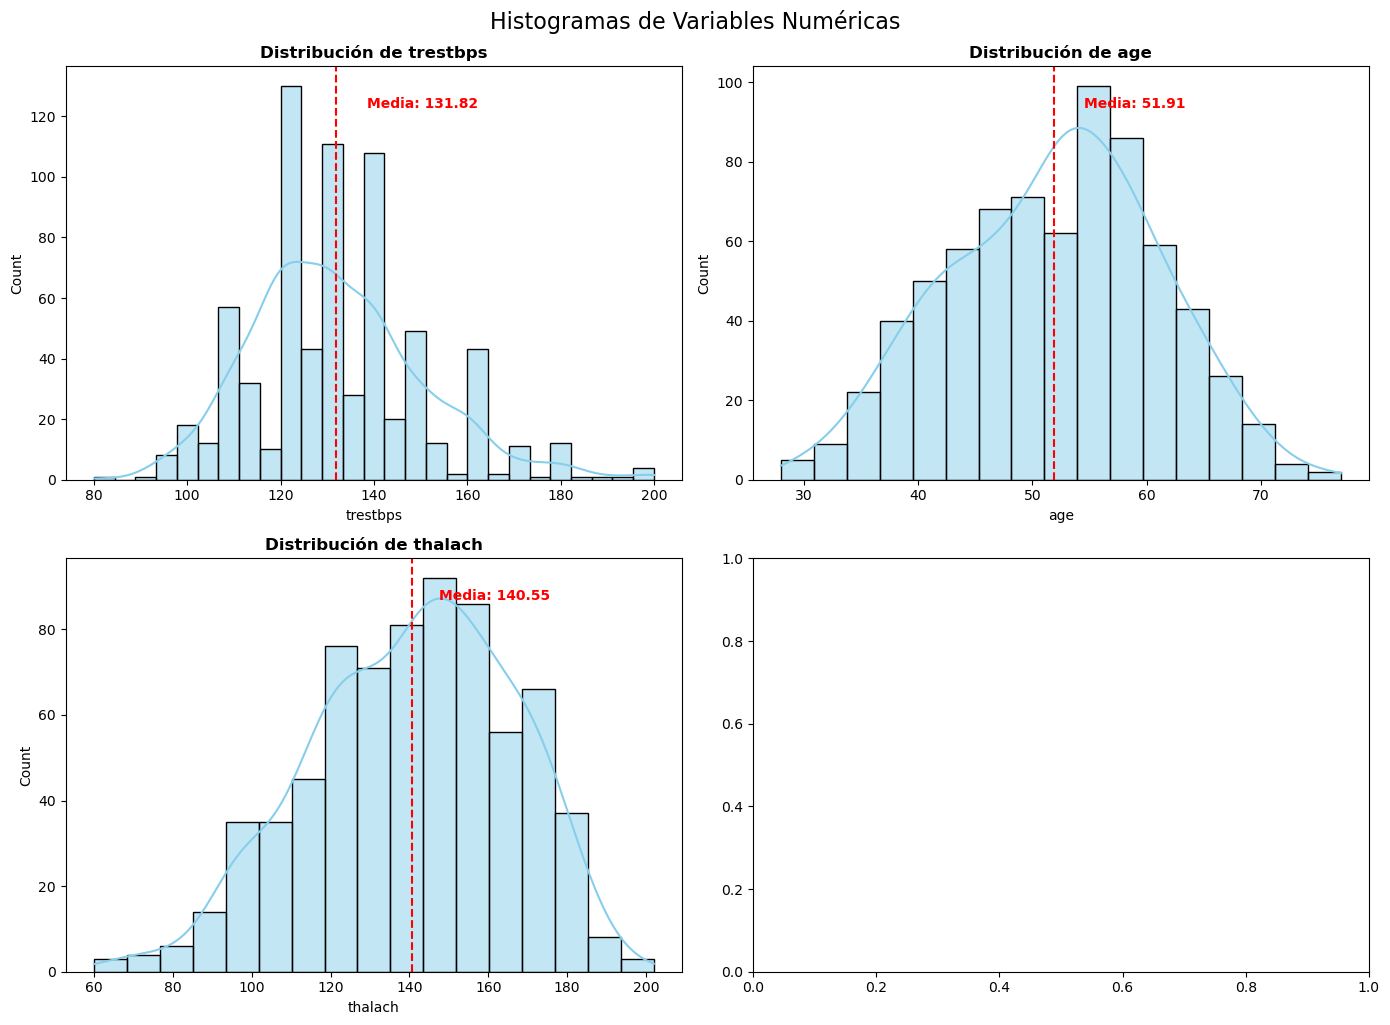

C:\Users\gabby\AppData\Local\Temp\ipykernel_18008\2379143292.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')


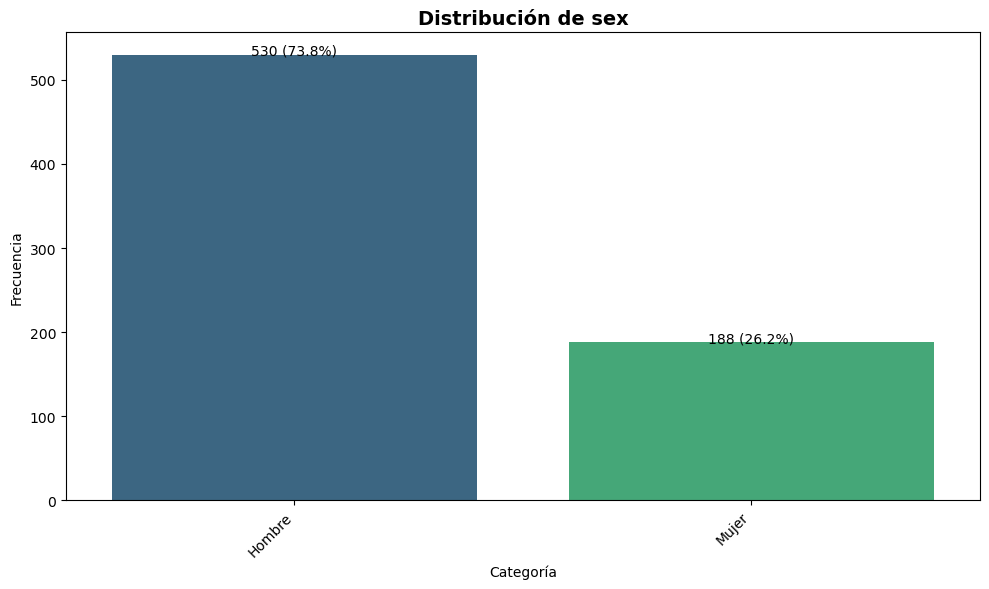

C:\Users\gabby\AppData\Local\Temp\ipykernel_18008\2379143292.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')


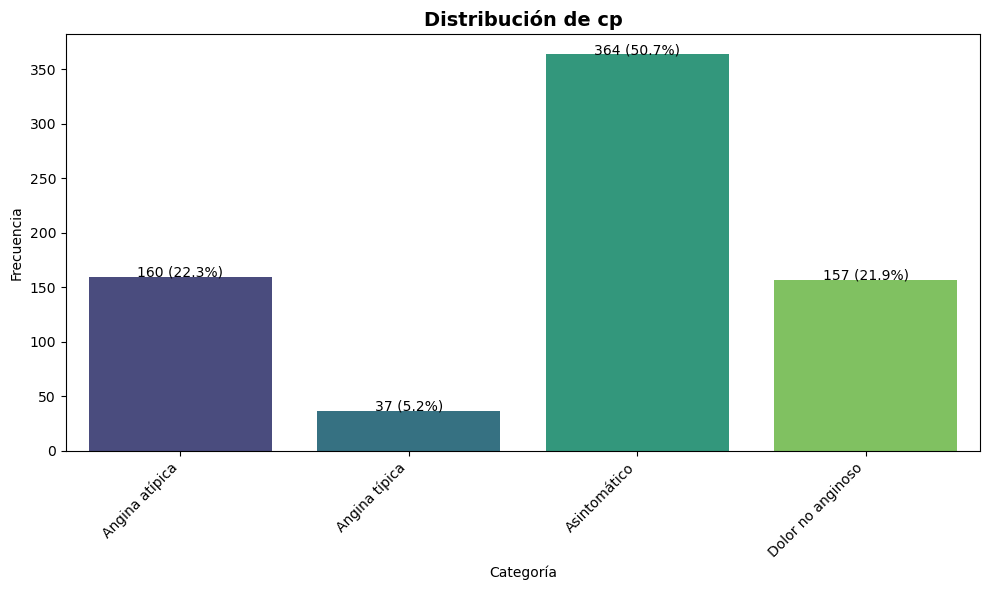

C:\Users\gabby\AppData\Local\Temp\ipykernel_18008\2379143292.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')


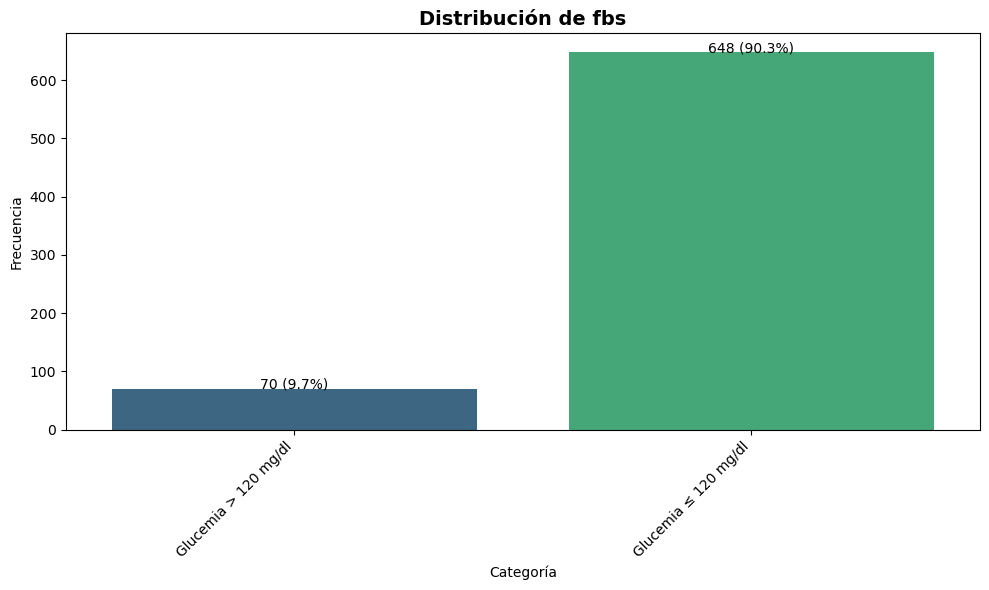

C:\Users\gabby\AppData\Local\Temp\ipykernel_18008\2379143292.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')


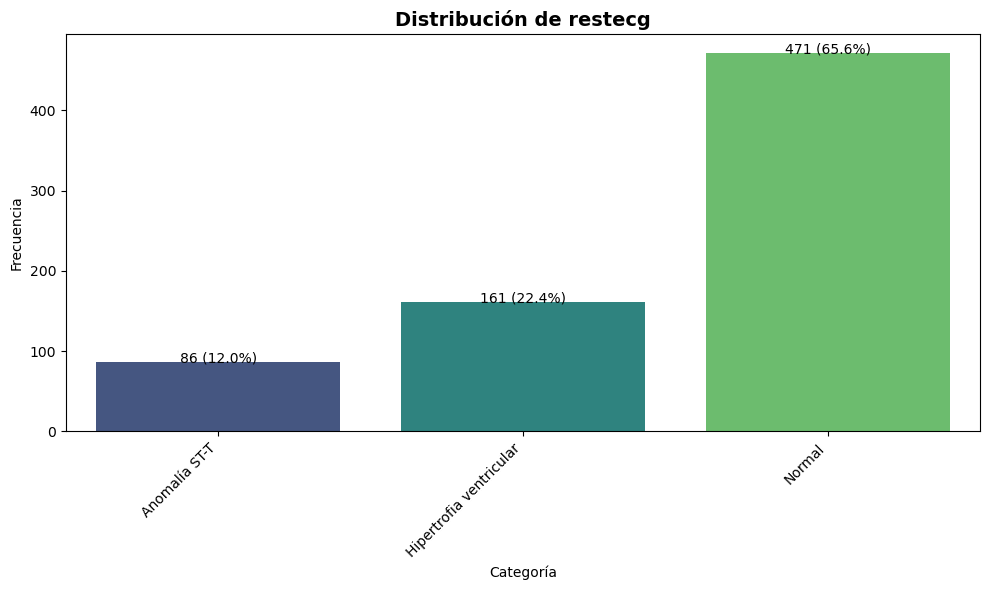

C:\Users\gabby\AppData\Local\Temp\ipykernel_18008\2379143292.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')


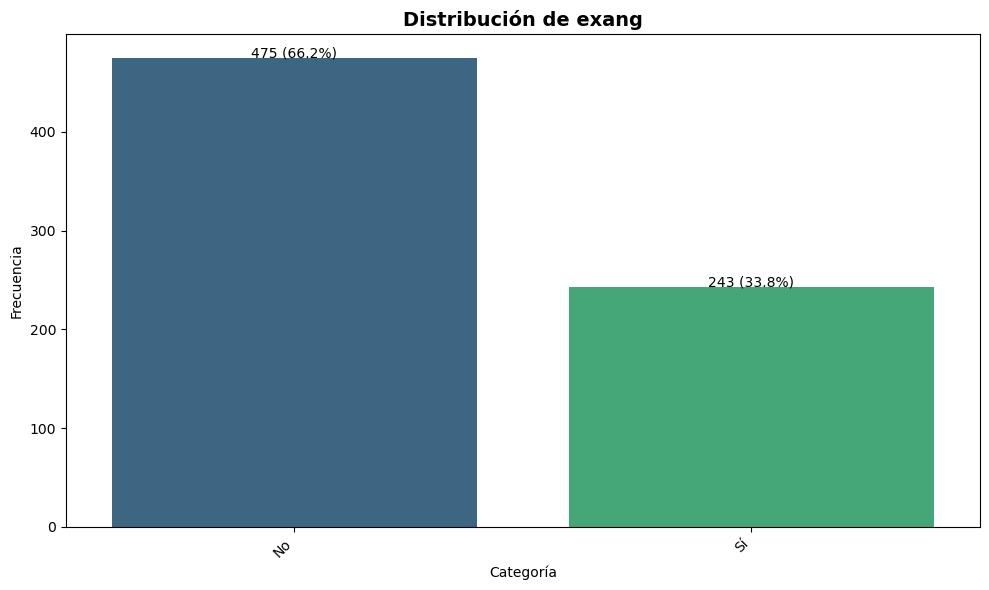

C:\Users\gabby\AppData\Local\Temp\ipykernel_18008\2379143292.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')


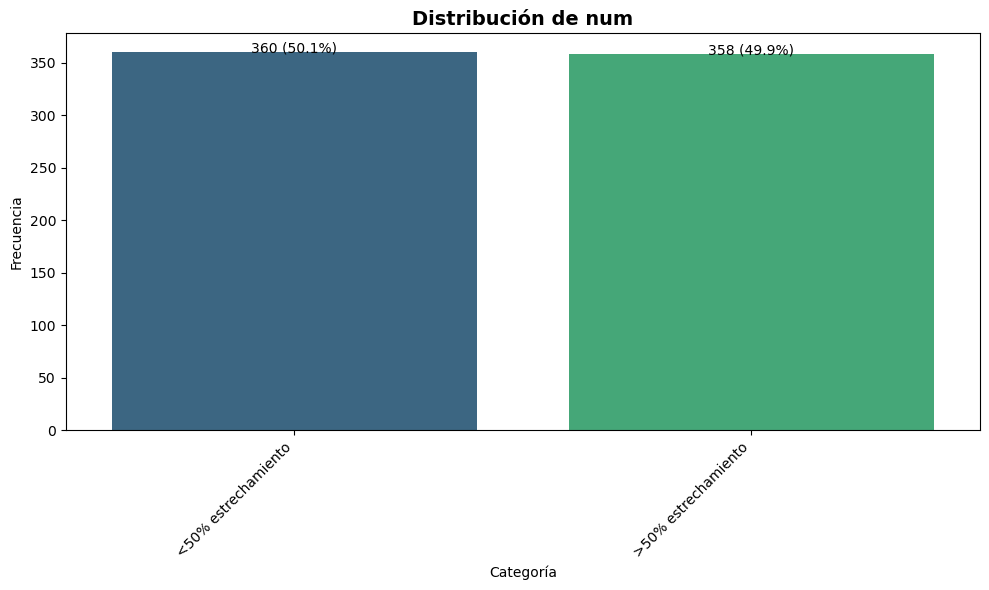

In [12]:
# 1. HISTOGRAMAS PARA VARIABLES NUMÉRICAS
variables_numericas = ['trestbps', 'age', 'thalach']

# Crear una figura con subplots para las variables numéricas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, var in enumerate(variables_numericas):
    # Histograma con curva de densidad
    sns.histplot(df[var], kde=True, ax=axes[i], color='skyblue', edgecolor='black')
    
    # Personalizar cada subplot
    axes[i].set_title(f'Distribución de {var}', fontsize=12, fontweight='bold')
    
    # Añadir una línea vertical para la media
    mean_val = df[var].mean()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=1.5)
    axes[i].text(mean_val*1.05, axes[i].get_ylim()[1]*0.9, f'Media: {mean_val:.2f}', 
                 color='red', fontweight='bold')

plt.tight_layout()
plt.suptitle('Histogramas de Variables Numéricas', fontsize=16, y=1.02)
plt.show()

# 2. GRÁFICOS DE BARRAS PARA VARIABLES CATEGÓRICAS
variables_categoricas = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'num']

# Diccionarios para etiquetar adecuadamente las variables categóricas
etiquetas = {
    'sex': {0: 'Mujer', 1: 'Hombre'},
    'cp': {1: 'Angina típica', 2: 'Angina atípica', 3: 'Dolor no anginoso', 4: 'Asintomático'},
    'fbs': {0: 'Glucemia ≤ 120 mg/dl', 1: 'Glucemia > 120 mg/dl'},
    'restecg': {0: 'Normal', 1: 'Anomalía ST-T', 2: 'Hipertrofia ventricular'},
    'exang': {0: 'No', 1: 'Sí'},
    'num': {0: '<50% estrechamiento', 1: '>50% estrechamiento'}
}

# Crear gráficos de barras para cada variable categórica
for var in variables_categoricas:
    plt.figure(figsize=(10, 6))
    
    # Obtener conteos y aplicar mapeo si existe
    if var in etiquetas:
        # Mapear valores a etiquetas descriptivas
        serie_mapeada = df[var].map(etiquetas[var])
        counts = serie_mapeada.value_counts().sort_index()
    else:
        counts = df[var].value_counts().sort_index()
    
    # Crear gráfico de barras
    ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')
    
    # Agregar etiquetas con conteos y porcentajes
    total = len(df[var])
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 0.1,
                f'{int(height)} ({100*height/total:.1f}%)',
                ha="center")
    
    # Personalizar gráfico
    plt.title(f'Distribución de {var}', fontsize=14, fontweight='bold')
    plt.xlabel('Categoría')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Aplicamos dummies a las variables discretas con tres o mas categorias ###

In [13]:
columnas_dummies = ['cp', 'restecg']

df = pd.get_dummies(df, columns=columnas_dummies)

In [14]:
X = df.drop("num", axis=1)
y = df["num"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

In [16]:
adaboost = AdaBoostClassifier(random_state=42)
adaboost.fit(X_train, y_train)


gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)


xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

c:\Users\gabby\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [17]:
models = {
    'AdaBoost': adaboost,
    'Gradient Boosting': gb,
    'XGBoost': xgb_model
}


--- Resultados para AdaBoost ---
Precisión (Accuracy): 0.7890
F1-Score: 0.7899

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       118
           1       0.79      0.79      0.79       119

    accuracy                           0.79       237
   macro avg       0.79      0.79      0.79       237
weighted avg       0.79      0.79      0.79       237



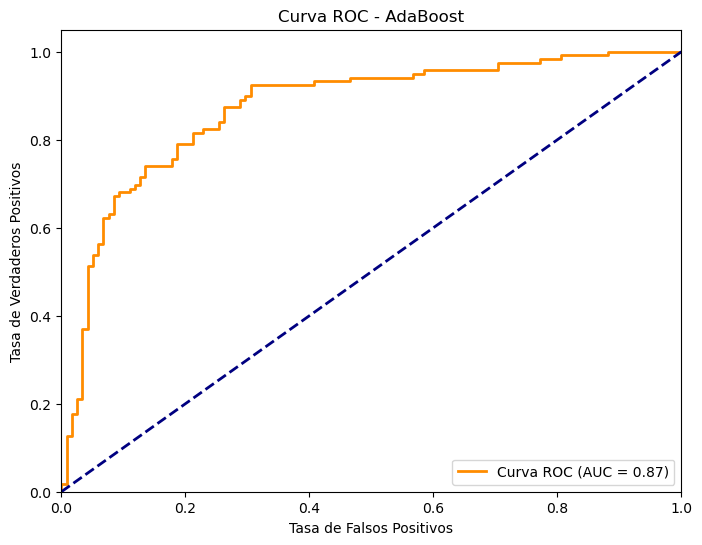


--- Resultados para Gradient Boosting ---
Precisión (Accuracy): 0.7975
F1-Score: 0.7983

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       118
           1       0.80      0.80      0.80       119

    accuracy                           0.80       237
   macro avg       0.80      0.80      0.80       237
weighted avg       0.80      0.80      0.80       237



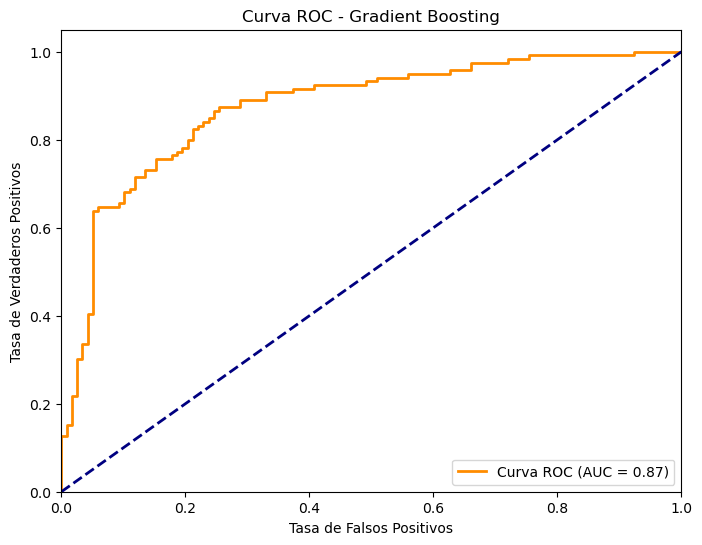


--- Resultados para XGBoost ---
Precisión (Accuracy): 0.7932
F1-Score: 0.7950

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       118
           1       0.79      0.80      0.79       119

    accuracy                           0.79       237
   macro avg       0.79      0.79      0.79       237
weighted avg       0.79      0.79      0.79       237



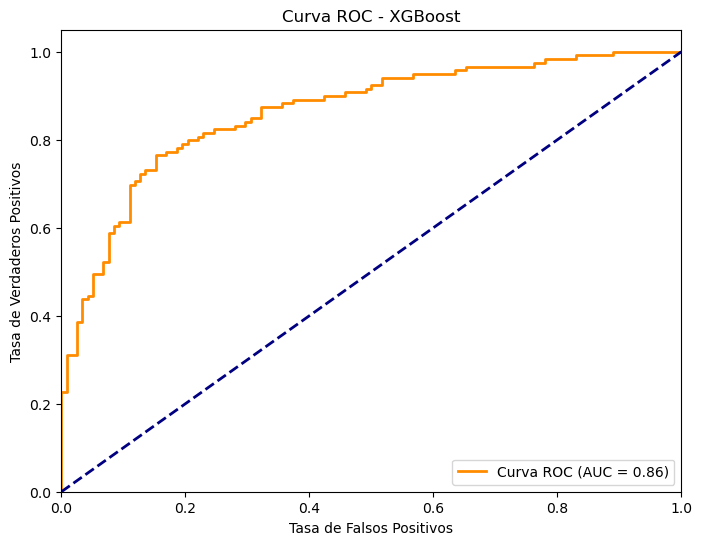

<Figure size 1200x600 with 0 Axes>

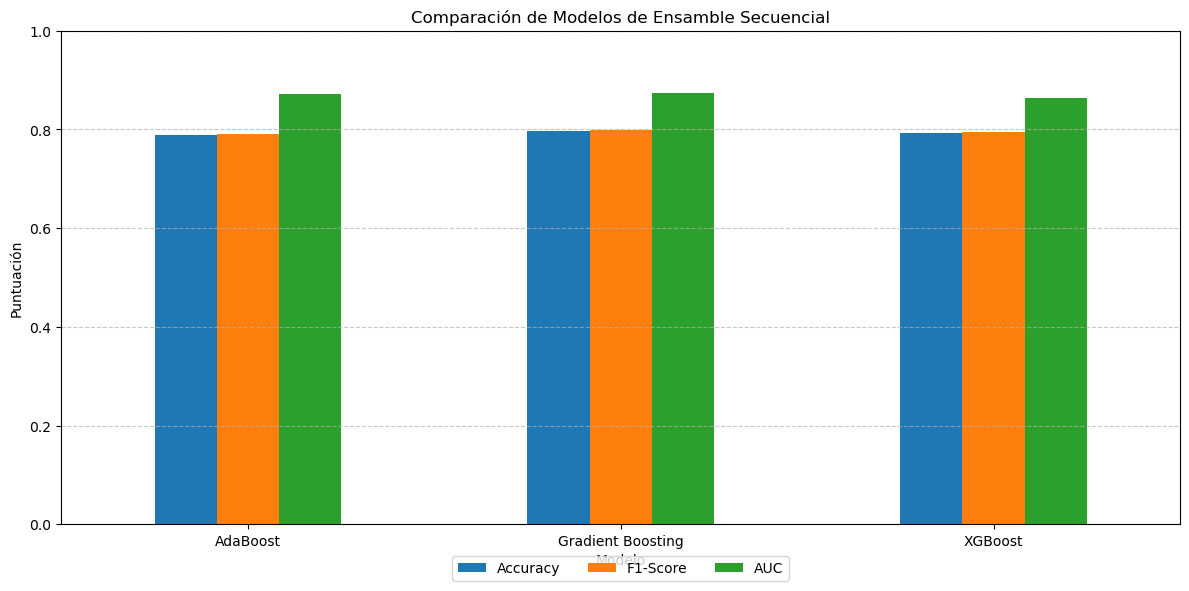


--- Tabla Comparativa de Resultados ---
                   Accuracy  F1-Score     AUC
AdaBoost             0.7890    0.7899  0.8725
Gradient Boosting    0.7975    0.7983  0.8746
XGBoost              0.7932    0.7950  0.8638


In [18]:
def evaluate_model(model, name):
   
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  
    
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n--- Resultados para {name} ---")
    print(f"Precisión (Accuracy): {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nInforme de clasificación:")
    print(classification_report(y_test, y_pred))

   
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'Curva ROC - {name}')
    plt.legend(loc="lower right")
    plt.show()
    
    return accuracy, f1, roc_auc


results = {}
for name, model in models.items():
    accuracy, f1, roc_auc = evaluate_model(model, name)
    results[name] = {'Accuracy': accuracy, 'F1-Score': f1, 'AUC': roc_auc}

results_df = pd.DataFrame(results).T
plt.figure(figsize=(12, 6))
results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Comparación de Modelos de Ensamble Secuencial')
plt.xlabel('Modelo')
plt.ylabel('Puntuación')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
plt.tight_layout()
plt.show()


print("\n--- Tabla Comparativa de Resultados ---")
print(results_df.round(4))


Buscando mejores parámetros para AdaBoost...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\gabby\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Mejores parámetros: {'learning_rate': 0.1, 'n_estimators': 100}

Buscando mejores parámetros para Gradient Boosting...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores parámetros: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Buscando mejores parámetros para XGBoost...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores parámetros: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

--- Resultados para AdaBoost (tuned) ---
Precisión (Accuracy): 0.8059
F1-Score: 0.8083

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       118
           1       0.80      0.82      0.81       119

    accuracy                           0.81       237
   macro avg       0.81      0.81      0.81       237
weighted avg       0.81      0.81      0.81       237



c:\Users\gabby\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:15:06] WARNING: D:\bld\xgboost-split_1737531311373\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


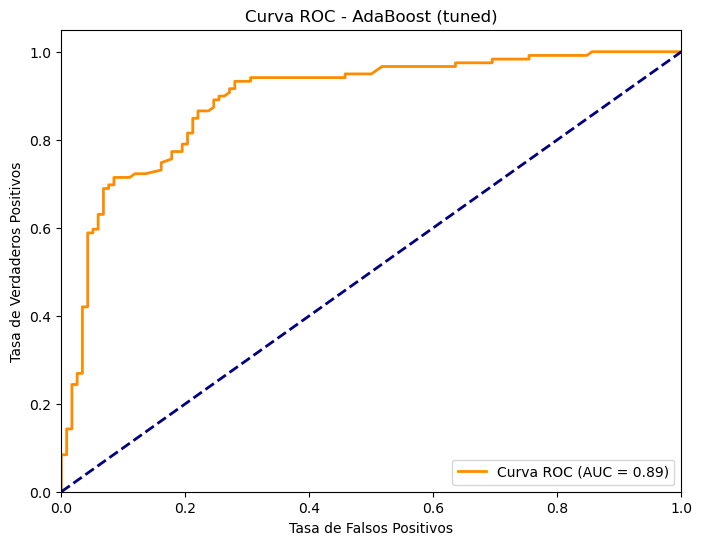


--- Resultados para Gradient Boosting (tuned) ---
Precisión (Accuracy): 0.8017
F1-Score: 0.8000

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       118
           1       0.81      0.79      0.80       119

    accuracy                           0.80       237
   macro avg       0.80      0.80      0.80       237
weighted avg       0.80      0.80      0.80       237



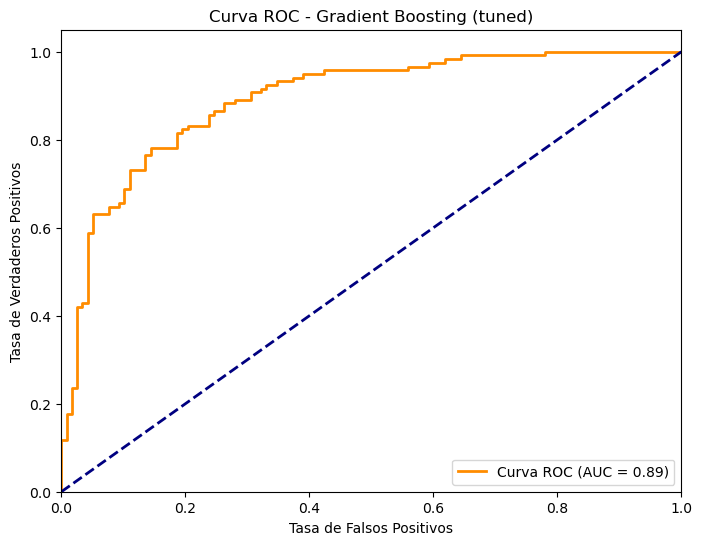


--- Resultados para XGBoost (tuned) ---
Precisión (Accuracy): 0.8059
F1-Score: 0.8051

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       118
           1       0.81      0.80      0.81       119

    accuracy                           0.81       237
   macro avg       0.81      0.81      0.81       237
weighted avg       0.81      0.81      0.81       237



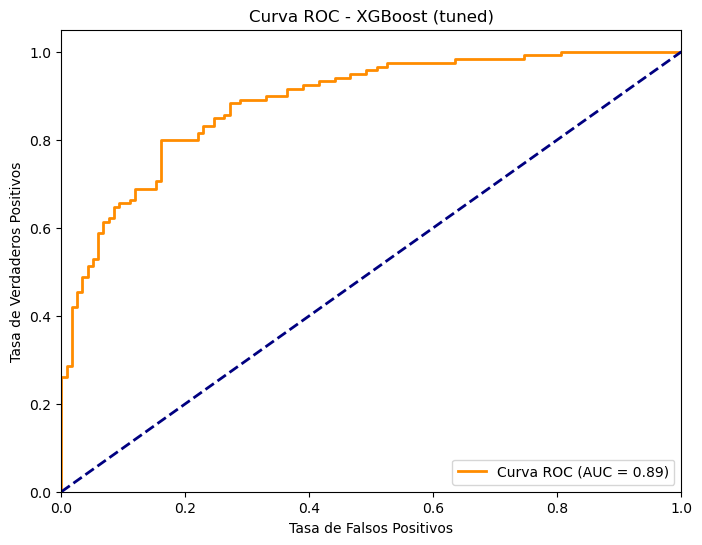

In [19]:

# Definimos los modelos base
base_models = {
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Hiperparámetros para buscar
param_grids = {
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    }
}

# Diccionario para guardar los mejores modelos
best_models = {}

for name in base_models:
    print(f"\nBuscando mejores parámetros para {name}...")
    
    grid = GridSearchCV(
        estimator=base_models[name],
        param_grid=param_grids[name],
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    print("Mejores parámetros:", grid.best_params_)
    
    best_models[name] = grid.best_estimator_

# Evaluar modelos tunings
tuned_results = {}
for name, model in best_models.items():
    accuracy, f1, roc_auc = evaluate_model(model, f"{name} (tuned)")
    tuned_results[name] = {'Accuracy': accuracy, 'F1-Score': f1, 'AUC': roc_auc}

tuned_results_df = pd.DataFrame(tuned_results).T

In [20]:
comparacion = pd.concat([
    results_df.add_suffix(" (default)"),
    tuned_results_df.add_suffix(" (tuned)")
], axis=1)

print("\n--- Comparación Default vs Tuned ---")
print(comparacion.round(4))


--- Comparación Default vs Tuned ---
                   Accuracy (default)  F1-Score (default)  AUC (default)  \
AdaBoost                       0.7890              0.7899         0.8725   
Gradient Boosting              0.7975              0.7983         0.8746   
XGBoost                        0.7932              0.7950         0.8638   

                   Accuracy (tuned)  F1-Score (tuned)  AUC (tuned)  
AdaBoost                     0.8059            0.8083       0.8907  
Gradient Boosting            0.8017            0.8000       0.8928  
XGBoost                      0.8059            0.8051       0.8858  


In [21]:
with open('best_models.pkl', 'wb') as file:
    pickle.dump(best_models, file)

print("¡Modelos guardados como 'best_models.pkl'!")

¡Modelos guardados como 'best_models.pkl'!
